Grade=100/100

Astro 361
Lab 4
Zack Felker

We seek to process our pre-observation data to gain information about the characteristics of the instruments associated with the Angell Hall Student Observatory. This occurrs in three parts: gain and read-noise, linearity, and darkcurrent. We will analyse CCD images saved as fits files to obtain values for gain and read-noise, characterize the response of the CCD as time increases, and finally examine the behavior of the CCD as temperature increases (so called dark current).

**Introduction:**

In order to detect incident photons, the CCD needs to convert from electrons to ADU. This ratio is called gain, and it leads to noise in the data. We can measure the gain and read-noise by taking flats and biases. Flats are images taken of a flat white surface. Biases are images taken with a shutter time of 0.

An ideal CCD responds linearly to incident photons. That is, the counts registered should be directly proportional to the incoming light. Every instrument has a point above which it becomes nonlinear. We will determine this point here.

As temperature increases, the probability that an electron will escape a well despite no photon striking the pixel increases exponentially. We can use nonlinear regression to fit dark current frames to the expected curve to determine the normalization constant and the energy gap for the CCD chip.

**Methods:**

We begin by importing libraries and reading in data.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from scipy import ndimage
from numpy import *
from scipy import optimize
from scipy import stats
#Takes: file name (str), number of files (int). 
#    [number] data sets in form [name] + "i" + ".fits" where i goes from 1 to [number]
#Returns: a list containing fits objects. 
def getData(name, number):
    out = []
    for i in range (1, number + 1):
        fileName = name + str(i) + '.fit'
        temp = fits.getdata(fileName)
        out.append(temp)
    return out
bias = np.array(getData('bias', 10))
flat = np.array(getData('flat', 10))
linearity = np.array(getData('linearity', 9))
dark = np.array(getData('dark', 14))
bias = np.float64(bias)
flat = np.float64(flat)
linearity = np.float64(linearity)
dark = np.float64(dark)
darkTemp = np.array([-10.2,-8.5, -2.3,1.9,5.8,8.4,10.7,12.6,14.5,\
                     15.9,17.5,18.5,19.5,20.0]) + 273.2
darkTemp = np.float64(darkTemp)

Gain and Read-Noise:

Gain is obtained by ((mean(F1)+mean(F2))-(mean(B1)+mean(B2)))/(variance(F2 - F1) - variance(B2 - B1)), where the Fs are flat field frames and Bs are bias frames. This requires a well defined mean for each bias and flat frame. Let's generate histograms to examine the distributions of flats and biases.

In [3]:
biasHist = bias.flatten()
plt.hist(biasHist, bins = 2400)
plt.xlim(1000, 1050)
plt.title('Bias Frames')
plt.xlabel('CCD Counts (ADU)')
plt.ylabel('Count')

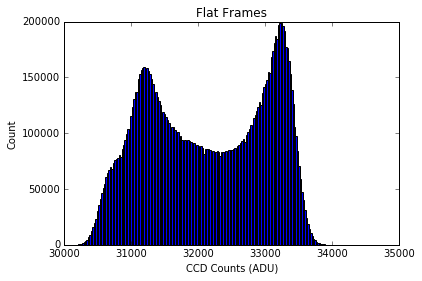

In [4]:
flatHist = flat.flatten()
plt.hist(flatHist, bins = 1000)
plt.xlim(30000, 35000)
plt.title('Flat Frames')
plt.xlabel('CCD Counts (ADU)')
plt.ylabel('Count')

We see that the values in bias frames are distributed reasonably normally. Not so with the flat frames. The strongly bimodal distribution will screw up our calculations as a result of an ill defined mean. The solution to this is to choose a group of pixels that have similar values and use only those to calculate gain. We chose a 10,000 pixel square, shown below.

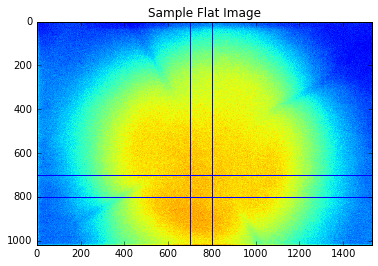

In [5]:
plt.imshow(flat[0], vmin = 30000, vmax = 35000)
plt.axhline(y=700)
plt.axhline(y=800)
plt.axvline(x=700)
plt.axvline(x=800)
plt.title('Sample Flat Image')

We again produce a histogram as above to ensure the mean is well defined.

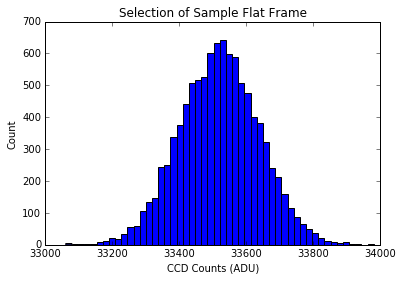

In [6]:
F = flat[0][700:800,700:800]
F = F.flatten()
plt.hist(F, bins = 50)
plt.title('Selection of Sample Flat Frame')
plt.xlabel('CCD Counts (ADU)')
plt.ylabel('Count')

That's much better. We can procede to apply the formula for gain. We loop over the available data in such a way as to sample all possible combinations of exposures exactly once. This gives us as many data points as possible from the distribution of measured gain values.

In [7]:
def gain(i, j, k, l):
    F1 = flat[i][700:800,700:800]
    F2 = flat[j][700:800,700:800]
    B1 = bias[k][700:800,700:800]
    B2 = bias[l][700:800,700:800]
    F = F1 - F2
    B = B1 - B2
    varF = np.var(F)
    varB = np.var(B)
    F1_mean = np.mean(F1)
    F2_mean = np.mean(F2)
    B1_mean = np.mean(B1)
    B2_mean = np.mean(B2)
    return ((F1_mean+F2_mean)-(B1_mean+B2_mean))/(varF - varB)

gains = []
for i in range (0, len(flat)):
    for j in range (i+1, len(flat)):
        for k in range (0, len(bias)):
            for l in range (k+1, len(bias)):
                gains.append(gain(i, j, k, l)) 
                
plt.hist(gains, bins = 50)
plt.title('Measured Gains')
plt.xlabel('Gain (e- / ADU)')
plt.ylabel('Count')

We find that the gain is somewhere in the neighborhood of 2.75 e- / ADU. This matches the value historically obtained for this instrument.

Read-noise is simply gain * standard deviation(B2 - B1) / sqrt(2). It is all but trivial to calculate this given the above. We again calculate as many values as possible given our inputs and display them in a histogram.

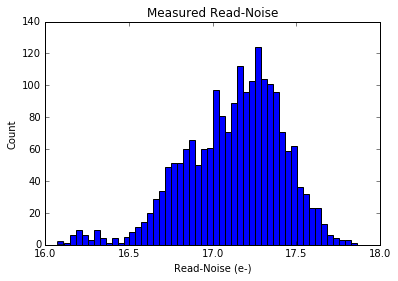

In [8]:
def readNoise(i, j, k, l):
    temp_gain = gain(i, j, k, l)
    B1 = bias[k][500:600,700:800]
    B2 = bias[l][500:600,700:800]
    B = B1 - B2
    stdB = np.std(B)
    return temp_gain * stdB / math.sqrt(2)


noise = []
for i in range (0, len(flat)):
    for j in range (i+1, len(flat)):
        for k in range (0, len(bias)):
            for l in range (k+1, len(bias)):
                noise.append(readNoise(i, j, k, l))       

plt.hist(noise, bins = 50)
plt.title('Measured Read-Noise')
plt.xlabel('Read-Noise (e-)')
plt.ylabel('Count')

We find a value for the readnoise of about 17.25 electrons. This matches what we expected for the instrument.

Linearity:

We want to determine the number of counts at which a pixel saturates and no longer behaves linearly. To do this, we compare exposure time, which is proportional to incoming photons, with counts. We encounter the same problem of well defined mean that we saw for flat fields. We employ the same solution, using the square of pixels defined above. We need only plot the mean of the pixel values for each exposure against the exposure time. We will also use the first 7 data points to produce a line that describes the behavior before the saturation point.

(0, 92923.897659999988)

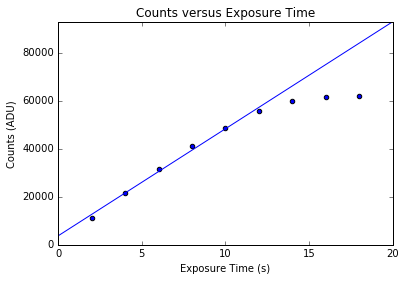

In [9]:
linearityList = []
for fit in linearity:
    linearityList.append(np.mean(fit[500:600,700:800]))

x = [2,4,6,8,10,12,14,16,18]
plt.scatter(x, linearityList)
m = stats.linregress(x[0:6], linearityList[0:6]).slope
b = stats.linregress(x[0:6], linearityList[0:6]).intercept
plt.plot([0,20], [m*x+b for x in [0,20]])
plt.title('Counts versus Exposure Time')
plt.xlabel('Exposure Time (s)')
plt.ylabel('Counts (ADU)')
plt.xlim(0,20)
plt.ylim(0,20*m + b)

We see that the behavoir begins to deviate from linearity around 55,000 ADU. This means that exposure times should be calibrated to keep the signal below this level.

Dark Current:

We want to fit our data taken at Angell Hall to the distribution: Counts = A*T^(3/2)exp(-Eg/2kT) + C where A and C are scaling and translation constants, and  Eg is the energy gap.

First, as above, we need to make sure we have a well defined mean. We expect the warmest of the frames to be the worst, so we'll examine that one.

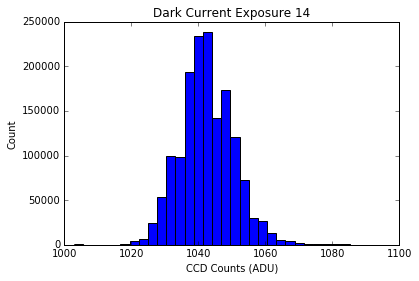

In [10]:
darkHist = dark[13].flatten()
plt.hist(darkHist, bins = 20000)
plt.xlim(1000, 1100)
plt.title('Dark Current Exposure 14')
plt.xlabel('CCD Counts (ADU)')
plt.ylabel('Count')

The distribution is symmetric enough to use the full exposure mean as a well defined value.

We can then apply an optimization routine to find values for A, E, and C.

In [11]:
BOLTZMANN = 8.617 * 10 ** -5 #eV / K
biasMean = np.mean(bias)
def fn(x, A, E, C):
    vec = []
    for X in x:
        temp = A * X ** 1.5 * math.exp(-1 * E / (2 * BOLTZMANN * X)) + C
        vec.append(temp)
    return vec
X = [darkTemp[i] for i in range (4, len(dark))]
Y = [np.mean(dark[i]) for i in range(4, len(dark))]
popt , trash = optimize.curve_fit(fn, X, Y, [10**8, 1.14, 1000],\
                                  maxfev = 10000)
A, E, C = popt
print 'A = ', A, 'ADU'
print 'C = ', C, 'ADU'
print 'E = ', E, 'eV'

A =  1.45852163792e+24 ADU
C =  1019.19926606 ADU
E =  3.07871265908 eV


To make sure it worked, lets plot the data and the fit.

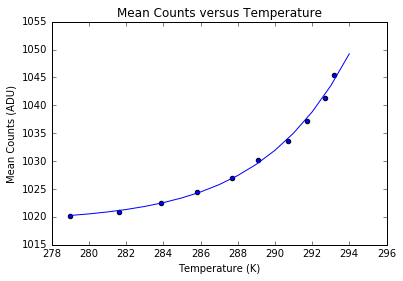

In [12]:
temps = [x for x in range (int(min(X)) , int(max(X)) + 2)]
plt.scatter(X, Y)
plt.plot(temps, [fn([x], A, E, C) for x in temps])
plt.title('Mean Counts versus Temperature')
plt.xlabel('Temperature (K)')
plt.ylabel('Mean Counts (ADU)')

We see that the two match extremely well. The value of 3.08 eV for the energy gap compares *interestingly* to the theoretical value of 1.14 eV. A and C are less meaningful.

**Conclusions:**

The values we obtain are all close to what we would expect for the instrument in question, with the exception of energy gap. For energy gap we get an error of almost 200%.

We have succeeded in the important part of the lab. That is, we have learned how to process these images, and are now familiar with the calculations involved.